# 数据读取

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
data = datasets.load_diabetes()
X,y = data.data,data.target

In [3]:
import pandas as pd 
X = pd.DataFrame(X,columns=data.feature_names)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

In [6]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3751.0250


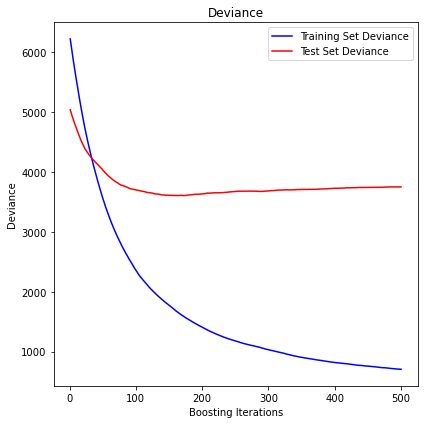

In [7]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

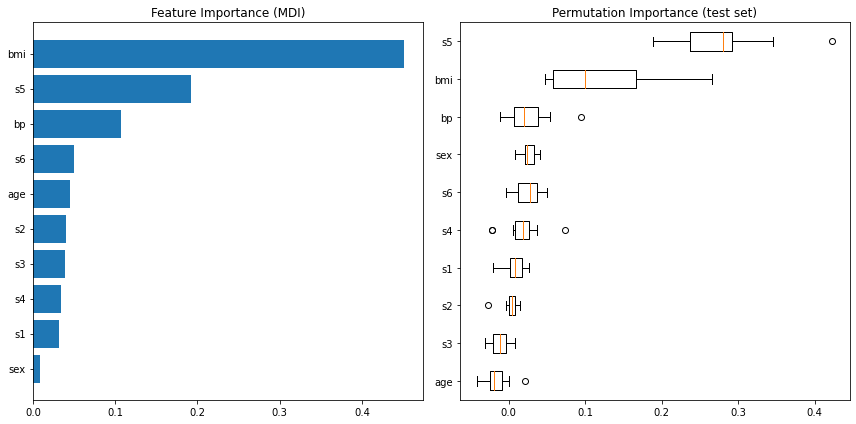

In [8]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
def Tuning(cv_params, other_params,x_train_array,y_train_):
    model2 = ensemble.GradientBoostingRegressor(**other_params)
    optimized_GBM = GridSearchCV(estimator=model2, 
                                 param_grid=cv_params,
                                 scoring='neg_mean_squared_error',
                                 cv=5, 
                                 n_jobs=-1)
    optimized_GBM.fit(x_train_array, y_train_)
    evalute_result = optimized_GBM.cv_results_['mean_test_score']
    print('每轮迭代运行结果:{0}'.format(evalute_result))
    print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    return optimized_GBM

In [10]:
other_params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
cv_params = {
    'n_estimators':np.arange(100,1000,20)
}
opt = Tuning(cv_params,other_params,X_train,y_train)

每轮迭代运行结果:[-3640.70666369 -3504.79239531 -3437.42495197 -3412.94710784
 -3375.76524154 -3362.54199037 -3348.60351575 -3340.16934044
 -3338.36882815 -3350.41057166 -3353.36757593 -3358.85105255
 -3362.79146525 -3367.27255714 -3369.9213843  -3369.77662453
 -3362.24714195 -3362.55084605 -3363.52878373 -3368.75857912
 -3366.74083531 -3364.44150297 -3365.35621818 -3372.57901488
 -3369.89268665 -3375.07962977 -3379.74734536 -3374.94042481
 -3376.84507317 -3375.89517108 -3381.87806318 -3386.63473922
 -3389.95777244 -3388.297821   -3392.89010873 -3388.05258631
 -3395.83436741 -3393.03145256 -3396.03523763 -3403.52129963
 -3403.03484022 -3412.59250995 -3411.47124343 -3413.7694034
 -3414.79122183]
参数的最佳取值：{'n_estimators': 260}
最佳模型得分:-3338.368828150512


Text(0, 0.5, 'MSE')

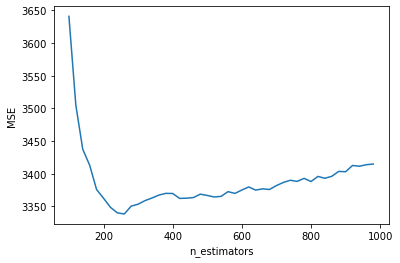

In [11]:
plt.plot(np.arange(100,1000,20),-opt.cv_results_['mean_test_score'] )
plt.xlabel('n_estimators')
plt.ylabel('MSE')

In [12]:
other_params = {'n_estimators': 260,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
cv_params = {
    'max_depth':np.arange(1,10,1)
}
opt = Tuning(cv_params,other_params,X_train,y_train)

每轮迭代运行结果:[-3453.55583329 -3237.67289372 -3241.85969149 -3335.85326381
 -3496.17678029 -3706.80795805 -3818.42499815 -3897.37424316
 -3997.86378589]
参数的最佳取值：{'max_depth': 2}
最佳模型得分:-3237.6728937202633


Text(0, 0.5, 'MSE')

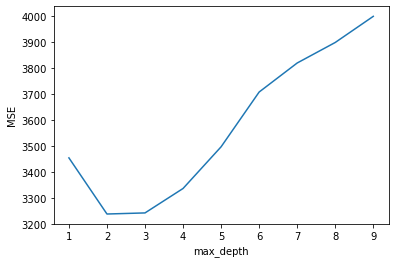

In [13]:
plt.plot(np.arange(1,10,1),-opt.cv_results_['mean_test_score'] )
plt.xlabel('max_depth')
plt.ylabel('MSE')

In [14]:
other_params = {'n_estimators': 260,
          'max_depth': 2,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
cv_params = {
    'learning_rate':np.arange(0.01,0.2,0.01)
}
opt = Tuning(cv_params,other_params,X_train,y_train)

每轮迭代运行结果:[-3237.68103247 -3217.98798916 -3213.27600272 -3234.14771946
 -3282.26559516 -3272.09763182 -3316.93319028 -3353.70442413
 -3386.67372802 -3435.57388796 -3467.11625331 -3582.83564807
 -3459.85353622 -3535.31002111 -3562.21881709 -3629.08470179
 -3559.25589482 -3674.12776905 -3623.85531065]
参数的最佳取值：{'learning_rate': 0.03}
最佳模型得分:-3213.276002719223


Text(0, 0.5, 'MSE')

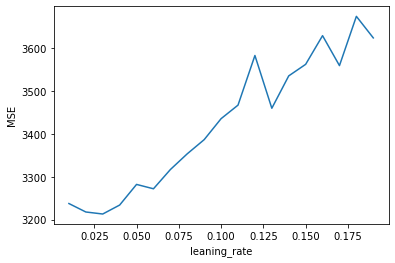

In [15]:
plt.plot(np.arange(0.01,0.2,0.01),-opt.cv_results_['mean_test_score'] )
plt.xlabel('leaning_rate')
plt.ylabel('MSE')

In [16]:
mse = mean_squared_error(y_test, opt.best_estimator_.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3162.2151


In [46]:
mse = mean_squared_error(y_test, opt.best_estimator_.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3392.2588
